In [1]:
import json

In [2]:
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/token2index.json', 'r') as f:
    token2index = json.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/index2token.json', 'r') as f:
    index2token = json.load(f)

In [3]:
from tensorflow.keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed

2023-10-01 16:28:06.997754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = load_model('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/models/s2s.keras')

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 16)       991680      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 10, 32),     6272        ['embedding[0][0]']          

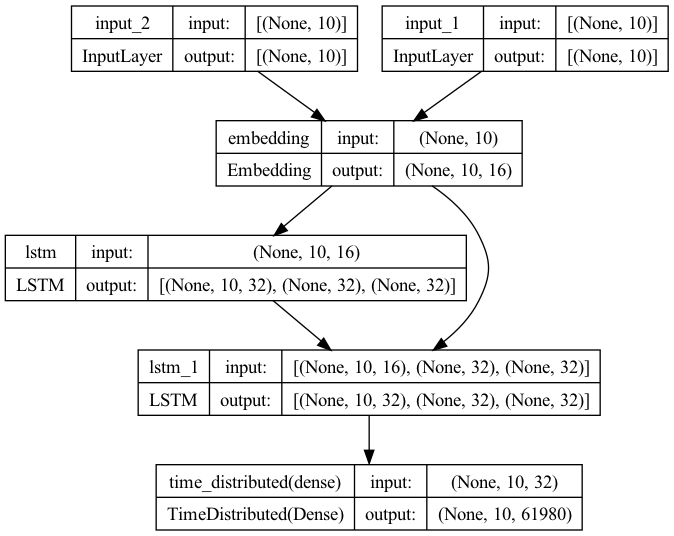

In [6]:
plot_model(model, show_shapes = True)

In [7]:
model.layers

In [8]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=model.layers[1].output, outputs=model.layers[3].output)

In [9]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 16)            991680    
                                                                 
 lstm (LSTM)                 [(None, 10, 32),          6272      
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 997,952
Trainable params: 997,952
Non-trainable params: 0
_________________________________________________________________


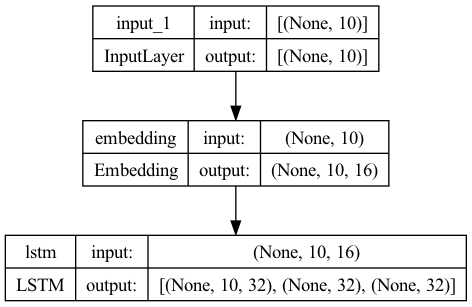

In [10]:
plot_model(encoder_model, show_shapes = True)

In [11]:
max_len = 10
embedding_dim = 16
latent_dim = 32

In [12]:
model.layers[0]
# model.layers[2](decoder_inputs)
# model.layers[4]

In [13]:
# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len, latent_dim))

decoder_inputs = Input(shape=(max_len, ))
# Get the embeddings of the decoder sequence
dec_emb2 = model.layers[2](decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = model.layers[4](dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = model.layers[5](decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [14]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 16)       991680      ['input_4[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                            

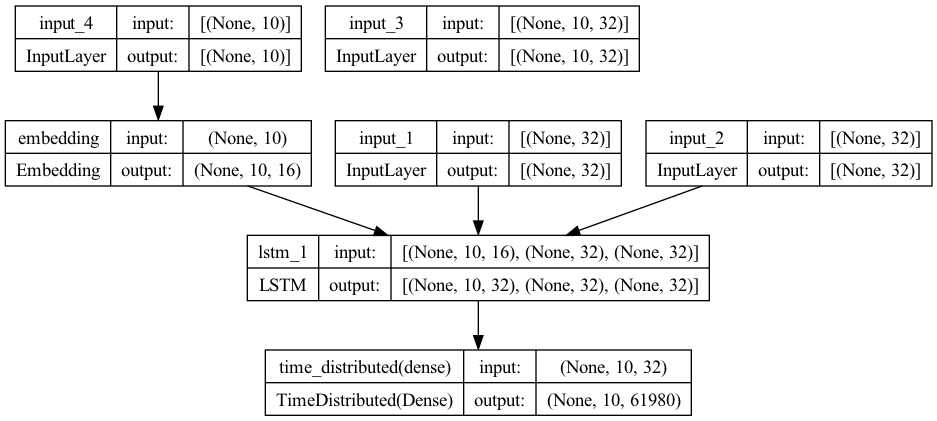

In [15]:
plot_model(decoder_model, show_shapes = True)

In [484]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = token2index.get('<BOS>')
    
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = index2token.get(str(sampled_token_index))

        if sampled_token != '<EOS>':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '<EOS>' or len(decoded_sentence.split()) \
            >= max_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [485]:
import numpy as np
from keras.utils import pad_sequences

In [486]:
my_seq = pad_sequences(np.array([[token2index.get(i) for i in 'what is your name'.split()]]), maxlen = max_len, padding = 'post', truncating = 'post')
my_seq

array([[25330, 45965,  7728, 59799,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [487]:
decode_sequence(my_seq)

1/1 [==============================] - 0s 18ms/step


' i am not know'

In [488]:
my_seq = pad_sequences(np.array([[token2index.get(i) for i in 'what'.split()]]), maxlen = max_len, padding = 'post', truncating = 'post')
my_seq

array([[25330,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [489]:
decode_sequence(my_seq)

1/1 [==============================] - 0s 19ms/step


' i am not know'

# TESTł

In [547]:
def decode_sequence_test(input_seq, output_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = output_seq

    (output_tokens, h, c) = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    
    return (i for i in np.argmax(output_tokens[0], axis = 1))

In [548]:
inout = pad_sequences(np.array([[token2index.get(i) for i in 'in a better place i'.split()]]), maxlen = max_len, padding = 'post', truncating = 'post')
output = pad_sequences(np.array([[token2index.get(i) for i in '<BOS> you are not gonna come back are you <EOS>'.split()]]), maxlen = max_len, padding = 'post', truncating = 'post')

In [549]:
tmp = decode_sequence_test(inout, output)

1/1 [==============================] - 0s 21ms/step


In [550]:
for i in tmp:
    print(i, index2token.get(str(i)))

25914 i
45119 am
29730 not
12703 know
12703 know
54178 <EOS>
54178 <EOS>
26514 you
12703 know
0 None
